# 1. Predicting Heart Disease Using a Classification Tree

## 1.1 Data Cleaning

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from econml.grf import CausalForest
from sklearn.linear_model import LinearRegression

In [2]:
# --- Leer datos ---
data = pd.read_csv("C:/Users/VICTOR/Documents/GitHub/Decision_Trees/R/input/processed.cleveland.data",
                   header=None)

# --- Renombrar columnas ---
data.columns = ['age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
                'restecg', 'thalach', 'exang', 'oldpeak',
                'slope', 'ca', 'thal', 'hd']

# --- Reemplazar "?" por NaN y eliminar ---
data = data.replace("?", np.nan).dropna()
data = data.apply(pd.to_numeric)

# --- Crear variable binaria de enfermedad ---
data['y'] = np.where(data['hd'] > 0, 1, 0)

# --- Variables categóricas ---
categorical_vars = ["cp", "restecg", "slope", "ca", "thal", "hd"]
for var in categorical_vars:
    data[var] = data[var].astype('category')

# --- Crear variables dummy ---
encoder = ce.OneHotEncoder(cols=categorical_vars, drop_invariant=True, use_cat_names=True)
data = encoder.fit_transform(data)


## 1.2 Data Analysis

Accuracy: 1.0
[[32  0]
 [ 0 28]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        32
           1       1.00      1.00      1.00        28

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



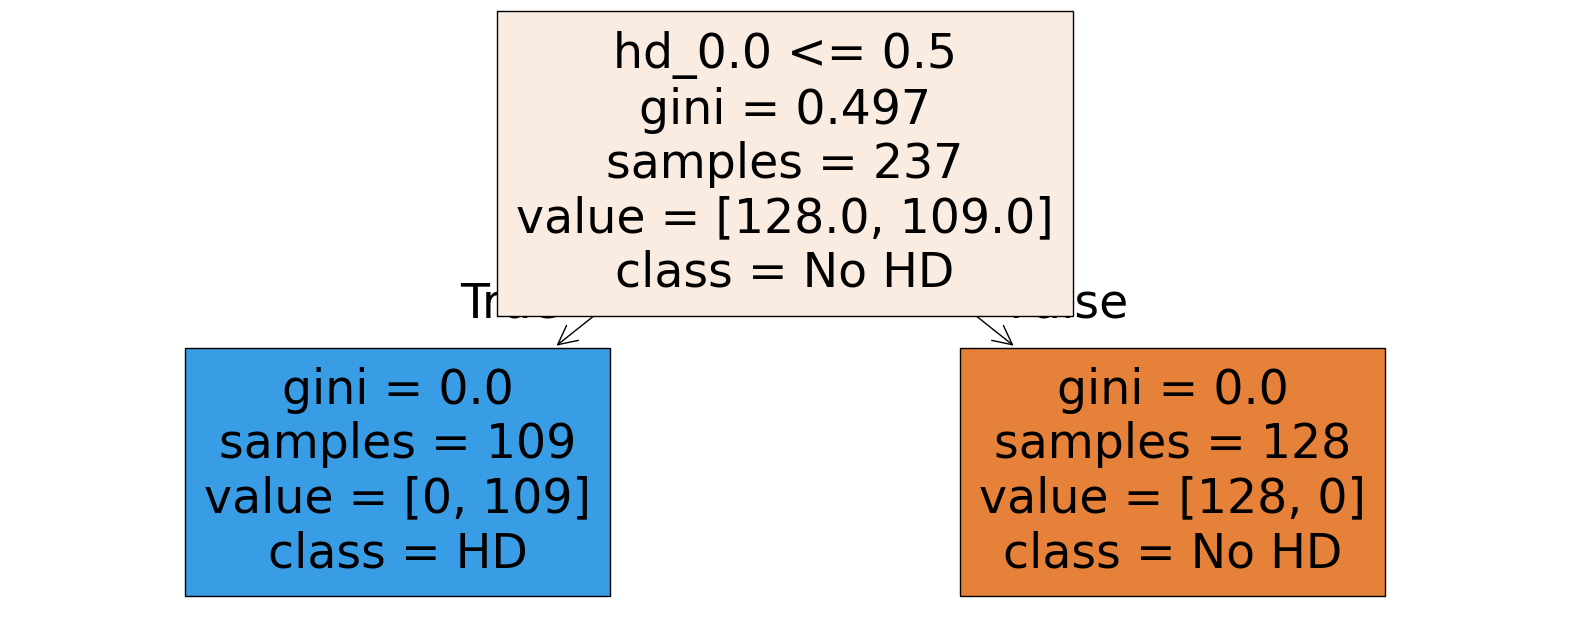

In [3]:

# --- Separar train y test ---
train, test = train_test_split(data, test_size=0.2, random_state=123, stratify=data['y'])

# --- Modelo de árbol de clasificación ---
X_train = train.drop(columns=['y'])
y_train = train['y']
X_test = test.drop(columns=['y'])
y_test = test['y']

tree_model = DecisionTreeClassifier(random_state=123)
tree_model.fit(X_train, y_train)
predictions = tree_model.predict(X_test)

# --- Métricas ---
print("Accuracy:", accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

plt.figure(figsize=(20, 8))
plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=["No HD", "HD"])
plt.show()

# 2. Causal Forest 

In [4]:
# --- Crear tratamiento simulado ---
n = data.shape[0]
data['T'] = np.random.binomial(1, 0.5, n)

# --- Outcome simulado ---
eps = np.random.normal(0, 1, n)
data['Y'] = (1 + 0.05 * data['age'] + 0.3 * data['sex'] + 0.2 * data['restbp']) * data['T'] + 0.5 * data['oldpeak'] * eps

# --- OLS simple ---
ols = LinearRegression().fit(data[['T']], data['Y'])
print("Efecto OLS promedio:", ols.coef_[0])

# --- Variables explicativas para heterogeneidad ---
X = data[['age', 'sex', 'restbp', 'chol', 'thalach', 'oldpeak']].to_numpy()
Y = data['Y'].to_numpy()
W = data['T'].to_numpy()

# --- Entrenar Causal Forest ---
cf = CausalForest(n_estimators=2000, random_state=123)
cf.fit(Y, W, X=X)

# --- Predicciones de efectos individuales ---
tau_hat = cf.effect(X)

# --- Importancia de variables ---
varimp = cf.feature_importances_
importance_df = pd.DataFrame({
    'variable': ['age', 'sex', 'restbp', 'chol', 'thalach', 'oldpeak'],
    'importance': varimp
}).sort_values(by='importance', ascending=False)

# --- Gráfico de importancia ---
sns.barplot(y='variable', x='importance', data=importance_df, color='steelblue')
plt.title("Feature Importances - Causal Forest")
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.show()

# --- Estandarizar covariables ---
X_std = pd.DataFrame(StandardScaler().fit_transform(X),
                     columns=['age', 'sex', 'restbp', 'chol', 'thalach', 'oldpeak'])

# --- Dividir efectos en terciles ---
data['tau_hat'] = tau_hat
data['tercile'] = pd.qcut(data['tau_hat'], 3, labels=[1, 2, 3])

# --- Calcular medias por tercil ---
means_by_tercile = X_std.assign(tercile=data['tercile']).groupby('tercile').mean().reset_index()
heatmap_data = means_by_tercile.melt(id_vars='tercile', var_name='variable', value_name='mean')

# --- Heatmap ---
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data.pivot('tercile', 'variable', 'mean'),
            cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Covariables estandarizadas por terciles del efecto estimado")
plt.xlabel("Covariables")
plt.ylabel("Terciles del efecto")
plt.show()

Efecto OLS promedio: 30.194128104299715


TypeError: CausalForest.fit() got multiple values for argument 'X'